In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import gamma
from scipy.special import factorial, comb
import random
from copy import deepcopy
#import tqdm

## Combinatorial problem formulations and QUBO funcs

###  Number partition problem 

Given a set $S$ of $N$ positive numbers 
$S = \{ n_{0}, \ldots , n_{N-1}\}$, is there a partition of $S$ into $P$ disjoint subsets $\{ R_0, \ldots , R_{P-1} \}$, such that the sum of values in 
each set is the same. I.e., can a set of $N$ assets with values $n_0, \ldots , n_{N-1}$ fairly be distributed between $P$ parties?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{p=0}^{P-1}  \left( \sum_{i=0}^{N-1} n_{i} x_{i, p} - \frac{1}{P} \sum_{i=0}^{N-1} n_{i} \right)^2 + M \sum_{i=0}^{N-1}  \left( 1- \sum_{p=0}^{P-1} x_{i, p} \right)^2 \, ,
\end{align}

and the decision variable $x_{i, p} \in \{0,1\}$ is defined as

\begin{align}
	x_{i, p} = 
    \begin{cases}
	1 & \text{if number } n_i \text{ of set } S \text{ is in set } R_p \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

- $P=4$: Number of subsets.
- $N$: Number of values in set $S$.
- ${\rm{bits}} = N \cdot P$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

Expanding the Hamiltonians $H = H_o + M H_p$:


$$
H_o = P\alpha^2 + \sum_{i,p} (n_i^2 - 2\alpha n_i) x_{ip} + \sum_{p, i \ne i^{'}} n_i n_{i^{'}} x_{ip} x_{i^{'}p}
$$
where $\alpha = \sum_i n_i/P$.

$$
H_p = N - \sum_{i,p} x_{ip} + \sum_{i, p \ne p^{'}} x_{ip} x_{ip^{'}}
$$

### Traveling salesman problem

Given a graph $G=(V,E)$ with $N=|V|$ nodes (cities), what is the cheapest hamiltonian cycle, considering the edge $e_{i,j}$ as the cost from going from city $i$ to city $j$?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}  + M \bigg[ \sum_{i=1}^{N}  \left( 1- \sum_{t=1}^{N} x_{t, i} \right)^2 + \sum_{t=1}^{N}  \left( 1- \sum_{i=1}^{N} x_{t, i} \right)^2  \bigg]\, ,
\end{align}

and the decision variable $\{x_{t, i}\}_{i,t=1,\dots,N} \in \{0,1\}^{N^2}$ is defined as

\begin{align}
	x_{t, i} = 
    \begin{cases}
	1 & \text{if city } i \text{ is visited at time step } t \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

The constraint enforces the decision matrix $[x]_{t, i}$ to be a permutation matrix, ordering the temporal visit of each city.

- $N$: Number of cities/nodes.
- ${\rm{bits}} = N^2$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.


Expanding the Hamiltonians $H = H_o + M H_p$:

$$
H_o = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}
$$

$$
H_p = 2N - 2\sum_{t,i}^{N} x_{ti} + \sum_{t,i}^{N} \biggl( \sum_{i^{'} \ne i}^{N} x_{ti} x_{ti^{'}} + \sum_{t^{'} \ne t}^{N} x_{ti} x_{t^{'}i} \biggr)
$$
where $N = N_{cities}$.

In [2]:
### QUBO functions

def L1_norm(Q, const):
    return const + np.sum(np.abs(Q))

def L1_norm_hot(Q, const, n_bits, temperature, max_prob_inf):
    return L1_norm(Q, const) + temperature*(n_bits*np.log(2) - np.log(max_prob_inf))

def build_numbs_set(N, P, seed):
    random.seed(seed)
    numbs = [int(1000*random.uniform(0.0, 1.0)) for _ in range(N)]
    total = sum(numbs)
    if numbs[-1] - (total % P) > 1:
        numbs[-1] -= (total % P)
    else:
        numbs[-1] += (P - (total % P))
    total = sum(numbs)
    return numbs

def idx_onehot(i, p, P):
    return i*P + p

def symmetrize(Q):
    return (Q + Q.T)/2

# NPP specific

def build_obj_NPP(numbs, N, P):
    H = np.zeros((N*P, N*P))
    alpha = np.sum(numbs)/P

    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = numbs[i]**2 - 2*alpha*numbs[i]
            for i_prime in range(N):
                if i_prime == i:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i_prime, p, P)] = numbs[i] * numbs[i_prime]
    const = P*alpha**2
    H = symmetrize(H)
    return H, const

def build_pen_NPP(N, P):
    H = np.zeros((N*P, N*P))
    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = -1
            for p_prime in range(P):
                if p_prime == p:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i, p_prime, P)] = 1
    const = N
    H = symmetrize(H)
    return H, const

def get_QUBO_NPP(N, P, M, seed, objective = True, penalization=True):
    # build a NPP QUBO with N integers, P partitions, M penalty factor, for problem identified with seed
    Q, const = np.zeros((N*P, N*P)), 0
    if objective:
        numbs = build_numbs_set(N, P, seed)
        Ho, const_o = build_obj_NPP(numbs, N, P)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_NPP(N, P)
        Q += M*Hp
        const += M*const_p
    return Q, const

# TSP specific


def build_adjacency(Nc, seed, circle_flag):
    if circle_flag:
        # trivial construction of adj. matrix of graph with N cities on a circle. Modify this function to get more complex structures
        coordinates = [(1_000_000 * np.cos((index / Nc) * 2 * np.pi), 1_000_000 * np.sin((index / Nc) * 2 * np.pi)) for index in range(Nc)]
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    else:
        # random construction of the adjacency matrix, based on euclidian distance. (cities are uniformly randomly placed inside a square)
        np.random.seed(seed)
        coordinates = 1e6 * np.array( [np.random.uniform(low = -1, high = 1, size = 2) for i in range(Nc)] )
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    return np.array(distance_table)

def build_obj_TSP(distances, Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot((t+1)%Nc, i_prime, Nc)] = distances[i, i_prime]
    H = symmetrize(H)
    const = 0
    return H, const

def build_pen_TSP(Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            H[idx_onehot(t, i, Nc), idx_onehot(t, i, Nc)] = -2
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot(t, i_prime, Nc)] += 1
            for t_prime in range(Nc):
                if t_prime != t:
                    H[idx_onehot(t, i, Nc), idx_onehot(t_prime, i, Nc)] += 1
    const = 2*Nc
    H = symmetrize(H)
    return H, const

def get_QUBO_TSP(Nc, M, seed, circle_flag = False, objective = True, penalization=True):
    # build a TSP QUBO with Nc cities, M penalty factor, for problem identified with seed
    Q, const = np.zeros((Nc**2, Nc**2)), 0
    if objective:
        distances = build_adjacency(Nc, seed, circle_flag)
        Ho, const_o = build_obj_TSP(distances, Nc)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_TSP(Nc)
        Q += M*Hp
        const += M*const_p
    return Q, const


### Generally useful functions

def nearest_to(ref_array, element):
    """
    Given a requested element (e.g. energy), returns the nearest value in a reference array, together with its position in the array
    """
    diff = np.abs(ref_array - element)
    idx = np.where(diff == np.min(diff))[0][0]
    return idx, ref_array[idx]

def remove_outliers(l, whisker_len = 1.5):
    q1, q3 = np.percentile(l, [25, 75])
    thres = q3 + whisker_len*(q3-q1)
    l = np.delete(l, l > thres)
    return l, thres

## Random sampling and Gibbs sampling

In [3]:
### Random Sampling functions

def evaluate_energy(solution, Q, const):
    return const + np.dot(solution, np.dot(Q, solution))

def sample_sol(N, P):
    return np.random.randint(0, 2, size = N*P)

def RandomSampler(Q, const, N, P, n_sample):
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        x = sample_sol(N, P)
        Es[j] = evaluate_energy(x, Q, const)
    return Es

def SpectralDistribution(Q, const, n_bits):
    ener = np.array([ evaluate_energy(state_inttobin(i, n_bits), Q, const) for i in range(2**n_bits)])
    return ener

def RandomSampler_Feasible_NPP(N, P, seed, n_sample):
    numbs = np.array(build_numbs_set(N, P, seed))
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        assign = np.random.randint(P, size = N)
        subset_sums = [ np.sum(numbs[assign == p]) for p in range(P)]
        Es[j] = P*np.var(subset_sums) # NB the objective energy can be reformulated as the variance of the subsets' sums (scaled by P)
    return Es

def RandomSampler_Feasible_TSP(Nc, seed, n_sample, circle_flag):
    adj = build_adjacency(Nc, seed, circle_flag)
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        permu = np.random.permutation(np.arange(Nc))
        Es[j] = cost_permutation(permu, adj)
    return Es

def cost_permutation(perm, adj):
    Nc = len(perm)
    cost = 0
    for i in range(Nc):
        cost += adj[perm[i], perm[(i+1)%Nc]]
    return cost



#### Gibbs Sampling functions

def state_inttobin(i, n):
    state_string = bin(i)[2:].zfill(n)
    return [int(b) for b in state_string]

def state_bintoint(b):
    b_numb = ''.join([str(k) for k in b])
    return int(b_numb, 2)

def compute_Gibbs_probs(beta, Q, const):
    n, _ = np.shape(Q)
    ener = np.array([ evaluate_energy(state_inttobin(i, n), Q, const) for i in range(2**n)])
    probs = np.exp(-beta*ener)
    probs /= probs.sum()
    return probs, ener # NOTE: ener (same for probs) are ordered so that i-th entry is the energy of the i-th state, i.e. the number i in binary. 

def sample_Gibbs(probs, eners, n_samples):
    eners_sampled = np.random.choice(eners, p = probs, size = n_samples)
    return eners_sampled

def perf_GibbsSampler(beta, Q, const, n_G_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs(probs, ener, n_G_samples)

N = 10, P = 2
Dim_RS: 18.33 +- 0.49 		beta_RS: 4.5e-06 +- 1.2e-07


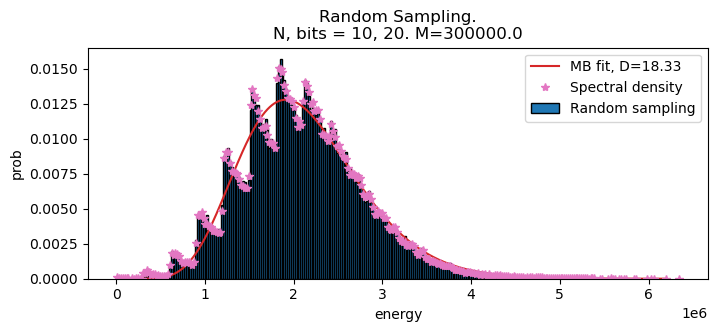

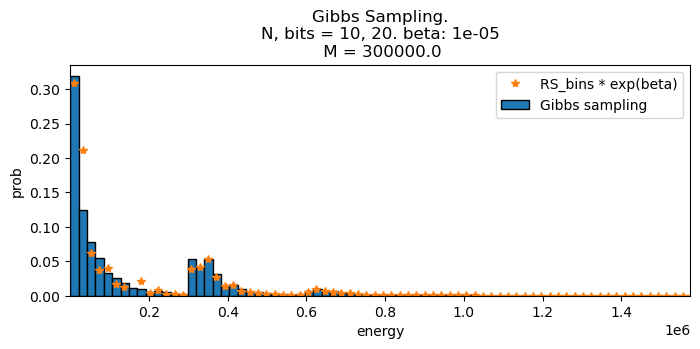

In [4]:
N, P = 10, 2
n_bits = N*P
print(f"N = {N}, P = {P}")
vseed = 45
M = 3e5
Q, const = get_QUBO_NPP(N, P, M, vseed)

# Start sampling data
n_RS_sample = 100_000
n_GS_sample = n_RS_sample
# create RS and Gibbs data
Es_RS = RandomSampler(Q, const, N, P, n_RS_sample)
Es_SD = SpectralDistribution(Q, const, n_bits)
beta = 1e-5 # 2e-5
Es_GS = perf_GibbsSampler(beta, Q, const, n_GS_sample)


def combine_SD(Es_SD, bin_width_RS, range):
    bins = int((range[1] - range[0])/bin_width_RS)
    counts, _ = np.histogram(Es_SD.flatten(), range = range, bins = bins)
    density_SD = counts / counts.sum() # normalize to get a probability
    return density_SD



### Random sampling
# get histogram data
bins = 300
fit_lim = None
counts, x_bins = np.histogram(Es_RS.flatten(), bins = bins)
density_RS = counts / counts.sum() # normalize to get a probability
x_pos_RS = (x_bins[1:] + x_bins[:-1])/2
bin_width_RS = x_bins[1]-x_bins[0]
mask = density_RS > 0 # filter out empty bins
density_RS, x_pos_RS = density_RS[mask], x_pos_RS[mask]
# plot RS
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos_RS, density_RS, width = bin_width_RS, edgecolor='k', linewidth=1, label ="Random sampling")
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Random Sampling.\nN, bits = {N}, {N*P}. M={M}")
# fit
if fit_lim == None:
    start, end = 0, -2
else:
    start, _ = nearest_to(x_pos_RS, fit_lim[0])
    end, _ = nearest_to(x_pos_RS, fit_lim[1])
XS = np.linspace(x_pos_RS[start], x_pos_RS[end], 1000)
f = lambda x, D, beta, normal : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width_RS * normal
coef_RS, coef_var = sp.optimize.curve_fit(f, x_pos_RS[start:end+1], density_RS[start:end+1], p0 = [5, 1e-7, 1])
coef_std = np.sqrt(np.diag(coef_var))
ax.plot(XS, f(XS, *coef_RS), color = "C3", label = f"MB fit, D={np.round(coef_RS[0], 2)}")
print(f"Dim_RS: {np.round(coef_RS[0], 2)} +- {np.round(coef_std[0], 2)} \t\tbeta_RS: {np.format_float_scientific(coef_RS[1], 1)} +- {np.format_float_scientific(coef_std[1], 1)}")
# plot SpectralDistribution on top of it
density_SD = combine_SD(Es_SD, bin_width_RS, range = (x_bins[0], x_bins[-1]+1))
ax.plot(x_pos_RS, density_SD[mask], "*", color = "C6", label = f"Spectral density")
ax.legend(fontsize = 10, loc='best')
plt.show()






### Gibbs sampling
# get histogram data
bins = int(bins * (np.max(Es_GS) - np.min(Es_GS))/(np.max(Es_RS) - np.min(Es_RS))) # in order to have same bin sizes wrt RS plot 
fit_lim = None
counts, x_bins = np.histogram(Es_GS.flatten(), bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width_GS = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot GS
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width_GS, edgecolor='k', linewidth=1, label ="Gibbs sampling")
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Gibbs Sampling.\nN, bits = {N}, {N*P}. beta: {beta}\n M = {M}")
# plot RandomSampling-GibbsEnhanced on top of it
density_RS_enhanced = density_RS * np.exp(-beta*x_pos_RS)
density_RS_enhanced /= np.sum(density_RS_enhanced)
ax.plot(x_pos_RS, density_RS_enhanced, "*", color = "C1", label = f"RS_bins * exp(beta)")
ax.legend(fontsize = 10, loc='best')
ax.set_xlim(np.min(Es_GS), np.max(Es_GS))
plt.show()

## M technique for Gibbs sampling

Implement method to choose penalty factor $M$.
Assumptions:
- Sampling is according to Gibbs factor (perfect Gibbs sampling). Generally, it differs from annealing sampling, since it doesn't suffer from local minima traps.
- A post-processing bit-swap local search is performed (this assumption may be dropped, but the math of the final formulation may get more involved). So it's actually perfect Gibbs followed by bit-swap.
- Estimation of the number of feasible solutions is given. Also, the number of infeasible solutions violating the constraints by $k = 1,2,\dots, k_{max}$ (e.g. $k_{max} = 4$) is given. In other words, the first infeasibilty peaks of $H_{pen}$ have been identified, either analytically or numerically.

TODO: show and explain final formula of the method

In [5]:
# Gibbs sampling with bit-swap

def state_inttobin(i, n):
    state_string = bin(i)[2:].zfill(n)
    return [int(b) for b in state_string]

def state_bintoint(b):
    b_numb = ''.join([str(k) for k in b])
    return int(b_numb, 2)

def perf_GibbsSampler_bitswap(beta, Q, const, nbits, n_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs_bitswap(probs, ener, n_samples, nbits)

def sample_Gibbs_bitswap(probs, eners, n_samples, nbits):
    states_sampled_int = np.random.choice(np.arange(2**(nbits)), p = probs, size = n_samples)
    for i in range(n_samples):
        states_sampled_int[i] = bitswap(states_sampled_int[i], eners, nbits)
    states_sampled_bin = [state_inttobin(x, nbits) for x in states_sampled_int]
    return eners[states_sampled_int], states_sampled_bin

def bitswap(state_int, eners, nbits):
    '''Performs bit-swap search: for all hamming distance 1 neighbours of the given state, returns the best one in terms of energy'''
    neighs_int = neighbours(state_int, nbits)
    eners_neigh = eners[neighs_int]
    if np.min(eners_neigh) < eners[state_int]:
        return neighs_int[ np.where(eners_neigh == np.min(eners_neigh))[0][0] ]
    return state_int

def neighbours(state_int, nbits):
    state_bin = state_inttobin(state_int, nbits)
    neighs_int = np.ndarray((nbits), dtype = int)
    for i in range(nbits):
        neigh_bin = deepcopy(state_bin)
        neigh_bin[i] = 1 - neigh_bin[i]
        neighs_int[i] = state_bintoint(neigh_bin)
    return neighs_int


# Gibbs sampling

def perf_GibbsSampler(beta, Q, const, nbits, n_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs(probs, ener, n_samples, nbits)

def sample_Gibbs(probs, eners, n_samples, nbits):
    states_sampled_int = np.random.choice(np.arange(2**(nbits)), p = probs, size = n_samples)
    eners_sampled = eners[states_sampled_int]
    states_sampled_bin = [state_inttobin(x, nbits) for x in states_sampled_int]
    return eners_sampled, states_sampled_bin


#### post-check

def count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f):
    cnt_feas,cnt_opt = 0, 0
    for i_state, state in enumerate(states):
        if np.isclose(evaluate_energy(state, Q_pen, const_pen), 0):
            cnt_feas += 1
            if Es[i_state] <= E_f:
                cnt_opt += 1
    return cnt_feas/len(states), cnt_opt/len(states)

NPP problem, size:  N = 9, P = 2
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 300000.0] at least 0.5, the chosen M is 418093.2641029358 (last violation peak used is 4)

Sampling prob. feasible = 0.9363  >= Sampling prob. feasible and energy in [0 , E_f=300000.0] = 0.9258
M_l1 in hot environment for this instance: 62262779.643063895


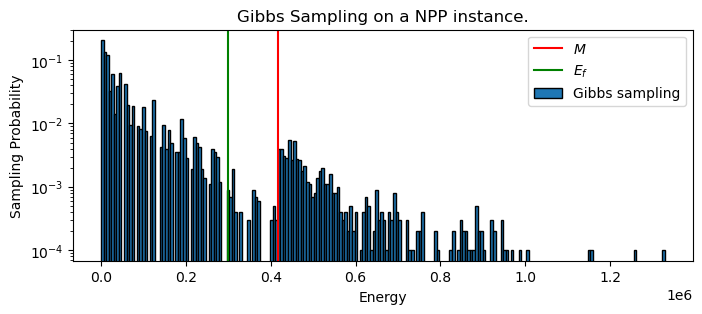

In [6]:
### Test M method (create problem, apply technique, simulate Gibbs sampling and plot)
from myalgo import M_method

# 1. set problem 
problem_type = "NPP"
if problem_type == "NPP":
    N, P = 9, 2
    n_bits = N*P
    size = (N, P)
    print(f"NPP problem, size:  N = {N}, P = {P}")
elif problem_type == "TSP":
    N_cities = 4
    n_bits = N_cities**2
    size = N_cities
    print(f"TSP problem, size:  N_citites = {N_cities}")
vseed = 42
circle_flag = False # for TSP: os True, the instances are generated on a circle like Fujitsu did, else, the cities are randomly placed

# 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
beta = 1e-5
peak_max = 4
min_pfeas = 0.5 # eta
E_f = 3e5

# 3. apply method to find penalty M
feas_version = "Ef, cumul-divided" # "Ef, cumul-unique" or "Ef, cumul-divided"
E_LB = 0
M = M_method(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_f, E_LB, feas_version, circle_flag).astype(float)

# 4. build QUBO with M and sample from it with Gibbs
n_sample = 10_000
if problem_type == "NPP":
    Q, const = get_QUBO_NPP(N, P, M, vseed)
    Q_pen, const_pen = get_QUBO_NPP(N, P, M, vseed, objective=False)
elif problem_type == "TSP":
    Q, const = get_QUBO_TSP(N_cities, M, vseed, circle_flag = False)
    Q_pen, const_pen = get_QUBO_TSP(N_cities, M, vseed, objective=False)

Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)
# measure sampling quality (feasibility and optimality)
feas_prob, opt_prob = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f)
print(f"\nSampling prob. feasible = {feas_prob}  >= Sampling prob. feasible and energy in [0 , E_f={E_f}] = {opt_prob}")

Q_obj, const_obj = get_QUBO_NPP(N, P, 0, vseed, penalization = False)
M_L1_hot = L1_norm_hot(Q_obj, const_obj, N*P, 1/beta, max_prob_inf = min_pfeas)
print(f"M_l1 in hot environment for this instance: {M_L1_hot}")

# 5. plot and check prob_feas for Gibbs and bit-swap
# get histogram data
bins ="auto"
counts, x_bins = np.histogram(Es.flatten(), bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1, label ="Gibbs sampling")
ax.set_ylabel("Sampling Probability")
ax.set_xlabel("Energy")
#ax.set_xlim(0, 2.2*M)
plt.title(f"Gibbs Sampling, {problem_type} instance, bits = {n_bits}.")
plt.title(f"Gibbs Sampling on a {problem_type} instance.")
for mul in range(1,2):
    ax.axvline(mul*M, color = "r", label = r"$M$")
#ax.axvline(M_L1_hot, color = "k")
ax.set_yscale("log")
ax.axvline(E_f, color = "g", label = r"$E_f$")
#ax.set_xscale("log")
ax.legend(fontsize = 10, loc='best')
plt.show()

#fig.savefig("Gibbs")

#### Varying max_peak

In [7]:
# ### Test M method (create problem, apply technique, simulate Gibbs sampling and plot)

# # 1. set problem 
# problem_type = "TSP"
# if problem_type == "NPP":
#     N, P = 9, 2
#     n_bits = N*P
#     size = (N, P)
#     print(f"NPP problem, size:  N = {N}, P = {P}")
# elif problem_type == "TSP":
#     N_cities = 4
#     n_bits = N_cities**2
#     size = N_cities
#     print(f"TSP problem, size:  N_citites = {N_cities}")
# vseed = 45


# # 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
# beta = 1e-5
# min_pfeas = 0.5 # eta
# E_f = 1e7


# # 3. apply method to find penalty M
# feas_version = "Ef, cumul-divided" # "Ef, cumul-unique" or "Ef, cumul-divided"
# E_LB = 0
# max_peaks_tested = np.arange(1, 5)
# feas_probs, opt_probs = np.ndarray((len(max_peaks_tested))), np.ndarray((len(max_peaks_tested)))
# for idx_peak, peak_max in enumerate(max_peaks_tested):
#     M = M_method(size, problem_type, vseed, beta, peak_max, min_pfeas, E_f, E_LB, feas_version)

#     # 4. build QUBO with M and sample from it with Gibbs
#     n_sample = 100_000
#     if problem_type == "NPP":
#         Q, const = get_QUBO_NPP(N, P, M, vseed)
#         Q_pen, const_pen = get_QUBO_NPP(N, P, M, vseed, objective=False)
#     elif problem_type == "TSP":
#         Q, const = get_QUBO_TSP(N_cities, M, vseed, circle_flag = False)
#         Q_pen, const_pen = get_QUBO_TSP(N_cities, M, vseed, objective=False)

#     Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)
#     # measure sampling quality (feasibility and optimality)
#     feas_probs[idx_peak], opt_probs[idx_peak] = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f)
#     print(f"Feasib. sampling prob is {feas_probs[idx_peak]}  >=  Feasible points ratio in [0 , E_f={E_f}] is {opt_probs[idx_peak]}")


# # 5. plot
# # plot
# fig = plt.figure(figsize=(8, 5))
# ax = fig.add_subplot(111)
# ax.plot(max_peaks_tested, feas_probs, "o", color = "C0", label = "feasible prob")
# ax.plot(max_peaks_tested, opt_probs, "o", color = "C1", label = "[feasible and E<Ef] prob")
# ax.set_ylabel("prob feaasible")
# ax.set_xlabel("max peak")
# plt.title(f"feasibility sampling probability, {problem_type} instance, bits = {n_bits}.\n beta: {beta}")
# ax.axhline(min_pfeas, color = "k", label = "min prob required")
# #ax.set_yscale("log")
# ax.legend(fontsize = 10, loc='best')
# plt.grid()
# plt.show()


## Other M-method tests

#### Test M method for various sizes, temperatures, tolerances and with/without refined method

In [45]:
Ns = np.array([7, 8, 9, 10])
betas_sampling = np.array([1e-3, 1e-5, 1e-7])
etas = np.array([0.1, 0.3, 0.5])
peak_max = 4
n_sample = 100_000

ratios_unref = np.ndarray((len(Ns), len(betas_sampling), len(etas)))
ratios_ref = np.ndarray((len(Ns), len(betas_sampling), len(etas)))

P = 2
vseed = 45
for N_idx, N in enumerate(Ns):
    n_bits = N*P
    for beta_idx, beta in enumerate(tqdm.tqdm(betas_sampling)):
        for eta_idx, min_pfeas in enumerate(etas):
            #print(N, beta, min_pfeas)
            for refined in [True, False]:
                M = M_method(N, P, beta, peak_max, min_pfeas, refined = refined)
                Q, const = get_QUBO_NPP(N, P, M, vseed)
                Es = perf_GibbsSampler_bitswap(beta, Q, const, N*P, n_sample)

                counts, x_bins = np.histogram(Es.flatten(), bins = "auto")
                density = counts / counts.sum()
                x_pos = (x_bins[1:] + x_bins[:-1])/2
                mask = density > 0
                density, x_pos = density[mask], x_pos[mask]
                ratio = np.sum(density[x_pos < M])
                if refined:
                    ratios_ref[N_idx, beta_idx, eta_idx] = ratio
                else:
                    ratios_unref[N_idx, beta_idx, eta_idx] = ratio

100%|██████████| 3/3 [05:35<00:00, 111.88s/it]


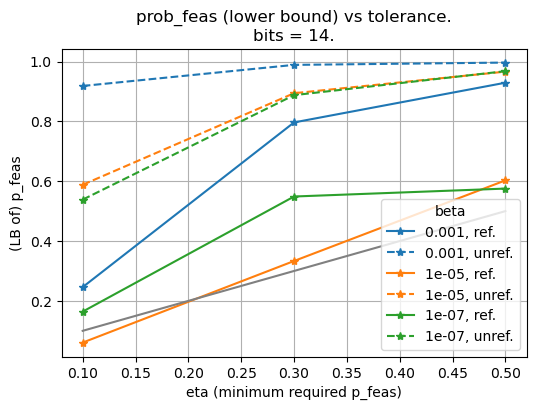

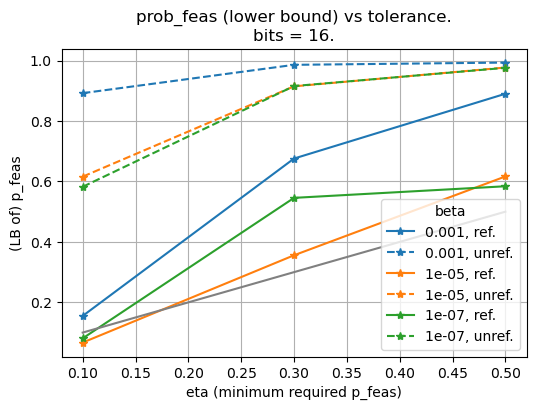

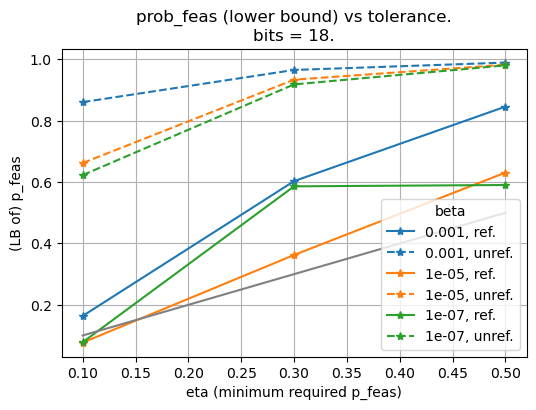

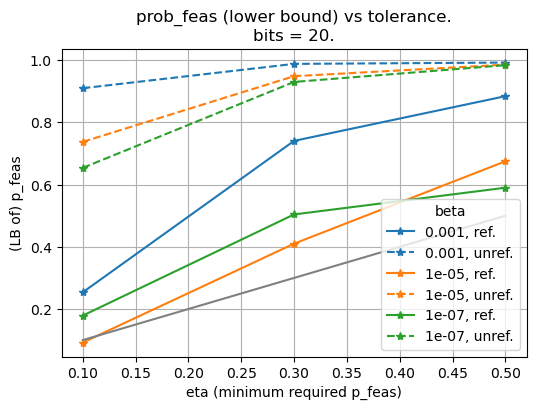

In [48]:
for N_idx, N in enumerate(Ns):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    for beta_idx, beta in enumerate(betas_sampling):
        ax.plot(etas, ratios_ref[N_idx, beta_idx], "-*", color = "C"+str(beta_idx), label = f"{beta}, ref.")
        ax.plot(etas, ratios_unref[N_idx, beta_idx], "--*", color = "C"+str(beta_idx), label = f"{beta}, unref.")
    ax.plot(etas, etas, color = "k")
    ax.set_ylabel("(LB of) p_feas")
    ax.set_xlabel("eta (minimum required p_feas)")
    plt.title(f"prob_feas (lower bound) vs tolerance.\nbits = {N*P}.")
    ax.legend(fontsize = 10, loc='best', title = "beta")
    plt.grid()
    plt.show()

#### testing the single bounds

In [ ]:
### Cumulative tests (testing Pf lower bound)

def cumulative_NPP(E_f, beta, N, P, seed, n_samples = 10_000):

    eners = RandomSampler_Feasible_NPP(N, P, seed, n_samples)

    # cumul-unique
    crude_cumul = np.sum(eners <= E_f)/len(eners)
    # cumul-divided
    n_chunks = 100
    E_LB = 0
    delta = (E_f - E_LB) / n_chunks
    cum_exp = np.sum([ np.exp(- beta * (E_LB + (j+1)*delta) ) * np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])

    for n_chunks in [1, 10, 1e2, 1e3, 1e4]:
        delta = (E_f - E_LB) / n_chunks
        cum_exp_tests = np.sum([ np.exp(- beta * (E_LB + (j+1)*delta) ) * np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])
        print(f"With {int(n_chunks)} chunks the integral is {cum_exp_tests}")
    
    # compute comulative by fitting
    bins = 100
    counts, x_bins = np.histogram(eners.flatten(), bins = bins)
    density = counts / counts.sum() # normalize to get a probability
    x_pos = (x_bins[1:] + x_bins[:-1])/2
    bin_width = x_bins[1]-x_bins[0]
    mask = density > 0 # filter out empty bins
    density, x_pos = density[mask], x_pos[mask]

    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1, label ="Random sampling")
    ax.axvline(E_f, color = "r")
    plt.show()

    print(f"Crude_cum_exp= {crude_cumul*np.exp(-beta*E_f)}\nCum_exp_divided= {cum_exp}")
    #cum_divided_test = np.sum([ np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])
    #print(f"Crude cumul= {crude_cumul}\nCum__divided= {cum_divided_test}")
    
    # XS = np.linspace(x_pos[0], x_pos[-1], 1000)
    # f = lambda x, D, beta, normal : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width * normal
    # ax.plot(XS, f(XS, *[.5, 2e-7, 1]), color = "C1")
    # coef, coef_var = sp.optimize.curve_fit(f, x_pos, density, p0 = [.5, 2e-7, 1])    
    # ax.plot(XS, f(XS, *coef), color = "C3", label = f"MB fit, D={np.round(coef[0], 2)}")
    return crude_cumul


N, P = 10, 4
E_f = 3e5
beta = 1e-3
seed = 45
cumul = cumulative_NPP(E_f, beta, N, P, seed)


## M test on DA-NPP dichotomic search

#### Da data

In [6]:
## import data
directory = "NPP_dichotomic/1/"
l_measures = 70 # it is the number of M-trials with dichotomic search [ i.e. the max of len( list( summary['measurements'].keys() ) )]
n_instances = 128

data_M, data_temp, data_rate, data_par = -np.ones((n_instances, l_measures)), -np.ones((n_instances, l_measures, 2)), -np.ones((n_instances, l_measures)), np.ndarray((n_instances, 2), dtype = int) # data_par is N, P at final index, in this order
data_values = {}


import os, json
files = np.sort([file for file in os.listdir(directory) if file[-4:] == "json"])


max_len_Ms = 0
for inst_idx, file in enumerate(files):

    filename =  directory+file
    if not os.path.isfile(filename):
        print(f"{filename} doesn't exist")
        continue

    with open(filename, 'r') as fp:
        summary = json.load(fp)
        data_par[inst_idx] = summary['N'], summary['P']
        Ms = list(summary['measurements'].keys())
        if len(Ms) > max_len_Ms:
            max_len_Ms = len(Ms)
        assert len(Ms) <= l_measures
        data_M[inst_idx, :len(Ms)] = Ms
        data_values[inst_idx] = summary['values']

        for M_idx, M in enumerate(Ms):
            data_temp[inst_idx, M_idx] = summary['measurements'][str(M)]['temperature_start'], summary['measurements'][str(M)]['temperature_end']
            data_rate[inst_idx, M_idx] = summary['measurements'][str(M)]['rate']
print(f'Read data --> Done')


data_M, data_temp, data_rate = data_M[:, :max_len_Ms], data_temp[:, :max_len_Ms], data_rate[:, :max_len_Ms]
l_measures = max_len_Ms


Read data --> Done


In [7]:
#idx, el_nearest = nearest_to(array, element)

def simulate_bisection(probability, inst_idx):
    M_history, rate_history, temp_i_history, temp_f_history = [], [], [], []
    M_low, M_high = 0, 2e9
    while True:
        M = int(.5 * (M_low + M_high))
        M_idx, M = nearest_to(data_M[inst_idx], M)
        rate_M = data_rate[inst_idx, M_idx]
        M_history.append(M)
        rate_history.append(rate_M)
        temp_i_history.append(data_temp[inst_idx, M_idx, 0])
        temp_f_history.append(data_temp[inst_idx, M_idx, 1])
        if rate_M > probability:
            M_high = M
        else:
            M_low = M
        if M_high - M_low < 100:
                break
    return np.array(M_history), np.array(rate_history), np.swapaxes( np.vstack((temp_i_history, temp_f_history)) , 0, 1)


prob = .5 # .25, .5 or .75
inst_idx = 0
M_history, rate_history,temps_history = simulate_bisection(prob, inst_idx)

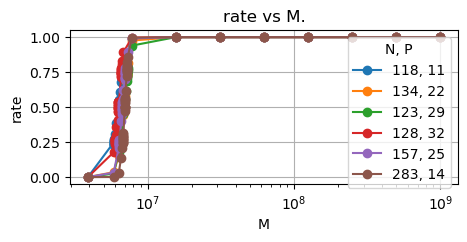

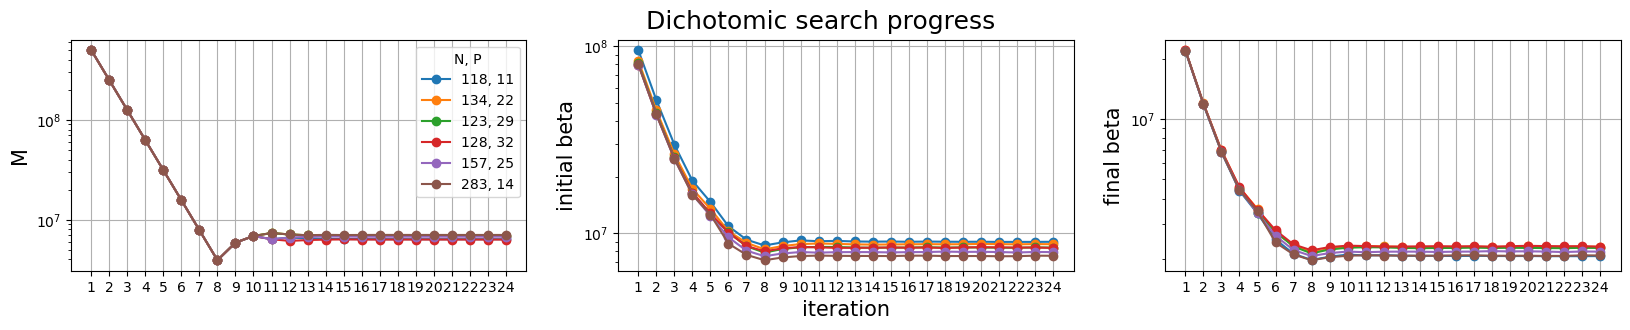

In [8]:
instances = [0, 1, 2, 3, 7, 8]


fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111)
for inst_idx in instances:
    mask = data_M[inst_idx] > 0
    ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
ax.set_ylabel("rate")
ax.set_xlabel("M")
ax.set_title(f"rate vs M.")
ax.set_xscale("log")
ax.legend(fontsize = 10, loc='best', title = "N, P")
plt.grid()
plt.show()

prob_target = .5
jump_first = 1
fig = plt.figure(figsize=(20,3))
plt.suptitle("Dichotomic search progress", fontsize = 18)
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
for inst_idx in instances:
    M_history, rate_history, temps_history = simulate_bisection(prob_target, inst_idx)
    ax1.plot(np.arange(jump_first, len(M_history)), M_history[jump_first:], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
    ax2.plot(np.arange(jump_first, len(M_history)), temps_history[jump_first:, 0], "-o")
    ax3.plot(np.arange(jump_first, len(M_history)), temps_history[jump_first:, 1], "-o")
ax2.set_xlabel("iteration", fontsize = 15)
ax1.set_ylabel("M", fontsize = 15)
ax2.set_ylabel("initial beta", fontsize = 15)
ax3.set_ylabel("final beta", fontsize = 15)
for ax in [ax1, ax2, ax3]:
    ax.set_yscale("log")
    ax.set_xticks(np.arange(jump_first, len(M_history)))
    ax.grid()
ax1.legend(fontsize = 10, loc='best', title = "N, P")
plt.show()

#### apply M

In [9]:
# apply M method to DA instances
from myalgo import M_method

# set parameters: temperature, min_probabilty, max_energy and violation_peaks
problem_type = "NPP"
feas_version = "Ef, cumul-divided" # "Ef, cumul-unique" or "Ef, cumul-divided"

E_LB = 0
peak_max = 4
min_pfeas = .5 # eta
E_f = 1e9 #? should be high since DA data refer to feasible only (need to stufy M(Ef) behavior to understand it better)

for inst_idx in range(2):
    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    N, P = data_par[inst_idx]
    size = (N, P)
    numbers_NPP = data_values[inst_idx]

    M_UB = M_method(size, problem_type, numbers_NPP, "numbers", beta, peak_max, min_pfeas, E_f, E_LB, feas_version)


For this instance, sampling temperature = 2.074e+06 and required probability in [0, E_f = 1000000000.0] at least 0.5, the chosen M is 23313163.314014673 (last violation peak used is 4)
For this instance, sampling temperature = 2.302e+06 and required probability in [0, E_f = 1000000000.0] at least 0.5, the chosen M is 26760614.942759275 (last violation peak used is 4)


For this instance, sampling temperature = 2.074e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 113266666.59442708 (last violation peak used is 4)


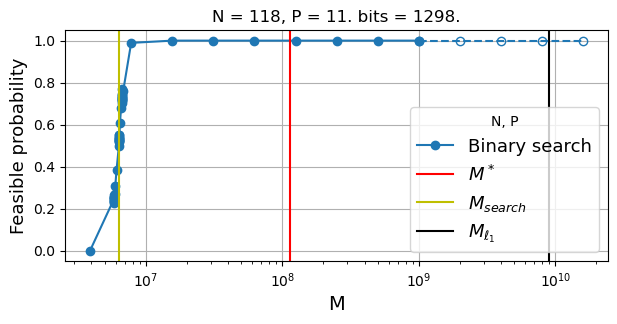

In [11]:
# set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
problem_type = "NPP"
feas_version = "Ef, cumul-divided" # "Ef, cumul-unique" or "Ef, cumul-divided"
E_LB = 0
peak_max = 4
min_pfeas = .5 # eta
E_f = 1e10

for inst_idx in np.arange(1):
    N, P = data_par[inst_idx]
    size = (N, P)
    numbers_NPP = data_values[inst_idx]

    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta_avg = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    M_UB_avg = M_method(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_f, E_LB, feas_version)

    M_trans_idx, _ = nearest_to(data_rate[inst_idx], min_pfeas)
    M_trans = data_M[inst_idx, M_trans_idx]
    # beta_trans = 1/data_temp[inst_idx, M_trans_idx, 1]
    # M_UB_trans = M_method_DA(size, problem_type, numbers_NPP, beta_trans, peak_max, min_pfeas, E_f, E_LB, feas_version)

    # L1 norm estimate of M
    Q_obj, const_obj = build_obj_NPP(numbers_NPP, N, P)
    M_L1 = L1_norm(Q_obj, const_obj)
    M_L1_hot = L1_norm_hot(Q_obj, const_obj, N*P, 1/beta_avg, max_prob_inf = min_pfeas)

    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot(111)
    mask = data_M[inst_idx] > 0
    #ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
    ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = "Binary search")
    ax.axvline(M_UB_avg, color = "r", label = r"$M^*$")
    ax.axvline(M_trans, color = "y", label = r"$M_{search}$")
    ax.axvline(M_L1_hot, color = "k", label = r"$M_{\ell_1}$")
    
    fake_points = np.array([1, 2, 4, 8, 16])*1e9
    ax.plot(fake_points, np.ones((len(fake_points))), "--o", color = "C0", fillstyle='none')
    
    ax.set_ylabel("Feasible probability", fontsize = 13)
    ax.set_xlabel("M", fontsize = 14)
    ax.set_title(f"N = {N}, P = {P}. bits = {N*P}.")
    ax.set_xscale("log")
    ax.legend(fontsize = 13, loc='best', title = "N, P")
    plt.grid()
    plt.show()

#fig.savefig("NPP_dichotomic")

### ratio M_UB / M_trans

For this instance, sampling temperature = 2.074e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 113266666.59442708 (last violation peak used is 4)
For this instance, sampling temperature = 2.302e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 116696344.63032708 (last violation peak used is 4)
For this instance, sampling temperature = 2.273e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 116942099.70301017 (last violation peak used is 4)
For this instance, sampling temperature = 2.317e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 117595910.851378 (last violation peak used is 4)
For this instance, sampling temperature = 1.916e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 114492068.24181601 (last violation peak used is 4)
For this instance, sampling temperature = 1.899e+06 and required probabi

For this instance, sampling temperature = 2.058e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 111231254.12268564 (last violation peak used is 4)
For this instance, sampling temperature = 2.232e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 116584278.5849236 (last violation peak used is 4)
For this instance, sampling temperature = 2.124e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 114953927.40471289 (last violation peak used is 4)
For this instance, sampling temperature = 2.249e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 115398812.63161078 (last violation peak used is 4)
For this instance, sampling temperature = 2.180e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 116394548.38586971 (last violation peak used is 4)
For this instance, sampling temperature = 2.276e+06 and required probab

For this instance, sampling temperature = 2.250e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 116888598.71355817 (last violation peak used is 4)
For this instance, sampling temperature = 2.265e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 116527927.74839327 (last violation peak used is 4)
For this instance, sampling temperature = 1.967e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 114136556.22163787 (last violation peak used is 4)
For this instance, sampling temperature = 2.208e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 116036113.7590371 (last violation peak used is 4)
For this instance, sampling temperature = 1.882e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 109367546.1015664 (last violation peak used is 4)
For this instance, sampling temperature = 2.169e+06 and required probabi

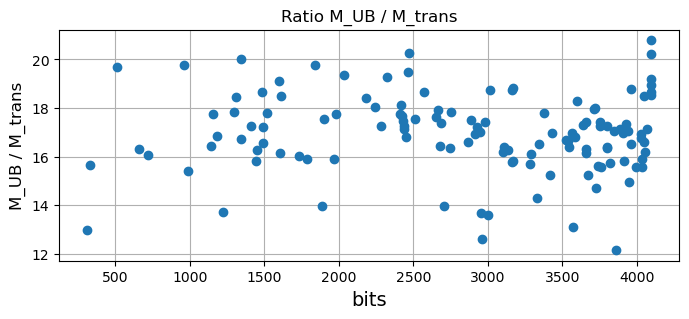

In [23]:
# ratio M_UB / M_transition
# (sorted according to number of bits) #TODO maybe according to N or P can be meaningful

ratios_M, bits_axes = np.ndarray((n_instances)), np.ndarray((n_instances))

problem_type = "NPP"
E_f = 1e10
min_pfeas = 0.5 # eta
E_LB = 0
peak_max = 4
feas_version = "Ef, cumul-divided" # "Ef, cumul-unique" or "Ef, cumul-divided"    

for inst_idx in range(n_instances):
    N, P = data_par[inst_idx]
    size = (N, P)
    bits_axes[inst_idx] = N*P
    ### compute transition M
    M_idx_trans, rate_trans = nearest_to(data_rate[inst_idx], .5)
    M_trans = data_M[inst_idx, M_idx_trans]
    ### compute M from recipe
    numbers_NPP = data_values[inst_idx]
    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta_avg = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    M_UB = M_method(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_f, E_LB, feas_version)
    # beta_single = 1 / np.mean(data_temp[N_idx, M_idx_trans, inst_idx, :, 1])
    # M_estimated_single = M_method(size, problem_type, numbers_NPP, "numbers", beta_single, peak_max, min_pfeas, E_f, E_LB, feas_version)

    ratios_M[inst_idx] = M_UB / M_trans
    
idx_sorted = np.argsort(bits_axes)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"Ratio M_UB / M_trans")                   
ax.plot(bits_axes[idx_sorted], ratios_M[idx_sorted],"o")
ax.set_ylabel("M_UB / M_trans", fontsize=12)
ax.set_xlabel("bits",fontsize=14)
#plt.yscale('log')
plt.grid()
